### University of Stirling
#### Computing Science and Mathematics
#### CSCU9YE - Artificial Intelligence

# Coursework: The Multi-dimensional Knapsack Problem

# Student Id: 2932358

## Aquiring the problem data

-  This function reads the data of a given problem instance
-  It returns four variables in the the following order, using the variable names as in the mathematical formulation described in the coursework
    - *n*: number of items, 
    - *m*: number of constraints
    - *p*: one dimensional numpy array with the profit coefficients fore ach item 
    - *r*: two dimensional numpy array with the resource coefficients for each item on each constraint/resource
    - *b*: one dimensional numpy array with the constraints right-hand size, that is the bounds or capacities 


In [1]:
import numpy as np

def read_multi_knapsack(fname):
    """
    Reads the data of a multi-knapsack instance

    :param fname: file name with instance data
    :return: n, m, p, r and b (as described above)
    """ 
    profits = []
    with open(fname, 'r') as kfile:
        lines = kfile.readlines()
        
    # convert m,n  to integer varaibles   
    n, m  = [int(d) for d in lines[0].split()]   # convert string data to integers
        
    input_line_cnt = 1    # input lines index after first line
    p = np.empty(0, dtype=np.int64)
    while p.size < n:
        d = np.loadtxt(lines[input_line_cnt].split(),
                       delimiter=" ", dtype=np.int64)
        p = np.append(p, d)
        input_line_cnt += 1

    r = np.empty((0, n), dtype=np.int64)
    for i in range(m):
        lin = np.empty(0, dtype=np.int64)
        while lin.size < n:
            d = np.loadtxt(lines[input_line_cnt].split(),
                           delimiter=" ", dtype=np.int64)
            lin = np.append(lin, d)
            input_line_cnt += 1
        r = np.vstack((r, lin))

    # get the capacities (max of one line space separated integer values)
    b = np.loadtxt(lines[input_line_cnt].split(),
                     delimiter=" ", dtype=np.int64)

    return  n, m, p, r, b, 


In [2]:
## Reading data from a file

data_file_name = "multi_knap_n28_m2.txt"        

n, m, profits, res, cap = read_multi_knapsack(data_file_name)

print("Instance Data:")
print(f"n: {n}.  m: {m}")
print(f"Profits: {profits}")
print(f"Resources: {res}")
print(f"Capacities: {cap}")


Instance Data:
n: 28.  m: 2
Profits: [ 1898   440 22507   270 14148  3100  4650 30800   615  4975  1160  4225
   510 11880   479   440   490   330   110   560 24355  2885 11748  4550
   750  3720  1950 10500]
Resources: [[ 45   0  85 150  65  95  30   0 170   0  40  25  20   0   0  25   0   0
   25   0 165   0  85   0   0   0   0 100]
 [ 30  20 125   5  80  25  35  73  12  15  15  40   5  10  10  12  10   9
    0  20  60  40  50  36  49  40  19 150]]
Capacities: [500 500]


## Part 1:
First, we will need to generate a valid solution, which means checking if the combination of items selected  doesn't exceed the capacity for each knapsack. To check its validity, we created the function ‘is_valid_solution’.

In [3]:
def is_valid_solution(solution, res, cap):
    """
    Checks if the provided solution is valid

    solution: A binary list representing the selected items
    res: matrix representing the resource consumption of each item in each knapsack
    cap: array representing the capacities of the knapsacks
    return: True if the solution is valid
    """
    total_consumption = np.dot(res, solution)
    for i in range(len(cap)):
        if total_consumption[i] > cap[i]:
            return False

    return True

Then, we'll need to generate a solution, which will be a binary list of size n, to represent all the items to include in the knapsacks. The choice of selected elements will be random, based on a fixed probability of 60% for 0s and 40% for 1s. The function will also check whether the solution generated is valid. If not, it will continue generating solutions until one is found.

In [4]:
import random as rnd

def generate_valid_random_solution(n, res, cap):
    """
    Generates a random valid solution
    Keeps generating solutions until a valid one is found
    
    n: items
    res: resource consumption matrix
    cap: capacities of the knapsacks
    return: list representing the selected items that form a valid solution
    """
    while True:
        solution = rnd.choices([0, 1], weights=[40, 60], k=n)
        if is_valid_solution(solution, res, cap):
            return solution


To evaluate the value (fitness) of a given solution, we need to take all the items selected and add their vaues together.

In [5]:
def evaluate_value(solution):
    """
    Evaluate the quality of a solution for the knapsack problem
    
    solution: list representing the solution
    return: tuple of the total value 
    """
    total_value = 0
    for item, selected in enumerate(solution):
        if selected:
            total_value += profits[item]
                
    return total_value

In [6]:
initial_solution = generate_valid_random_solution(n, res, cap)
v_solution = evaluate_value(initial_solution)
print(f"value: {v_solution}")

value: 46058


A function similar to evaluate_value is added, so that it returns not just the value for a solution, but also the weights (usages) for each knapsack. This will later be used for analytic purposes.

In [7]:
def evaluate_solution(sol):
    """
    Evaluate the quality of a solution for the knapsack problem
    
    sol: list representing the solution 
    return: tuple of the total value and a list of total weights for each constraint of the solution
    """
    total_value = 0
    total_weights = [0] * m
    
    for item, selected in enumerate(sol):
        if selected:
            total_value += profits[item]
            for knapsack in range(m):
                total_weights[knapsack] += res[knapsack][item]
                
    return total_value, total_weights

In [8]:
sol_value, total_usages = evaluate_solution(initial_solution)
print(f"Solution Value:  {sol_value} \nSolution Weights: {total_usages}")

Solution Value:  46058 
Solution Weights: [470, 448]


To generate a neighbour solution, we take the solution we have just generated and flip a random bit, so that if the bit is 0 becomes 1 and viceversa.

In [9]:
def generate_neighbour(sol):   
    """ 
    Generation of a solution similar to the one passed as parameter, flipping a random bit
    
    sol: solution as binary list
    return:  neighbour solution 
    """
    neig = sol.copy()                 
    i = rnd.randint(0,n-1)
    # flipping the bit
    neig[i] = 0 if sol[i]== 1 else 1
    return neig

In [10]:
neighbour_solution = generate_neighbour(initial_solution)
neighbour_value = evaluate_value(neighbour_solution)
print(f"neighbour_value: {neighbour_value}")

neighbour_value: 60206


Now we can put all the functions together in a hill_climber algorithm, that for a specified amount of iterations will create and evaluate a neighbour of a given solution. Then, will compare the values, keeping just the best one found.

In [11]:
def hill_climber(initial_solution, res, cap, num_iterations=2000):
    """
    Hill climbing algorithm implementation

    initial_solution: list representing the initial solution
    res: consumption matrix
    cap: capacities of the knapsacks
    num_iterations: iterations to run the algorithm
    return: best solution found and its value
    """
    total_values = []
    iteration_numbers = []
    current_solution = initial_solution
    current_value = evaluate_value(current_solution)

    for iteration in range(num_iterations):
        new_solution = generate_neighbour(current_solution)
        
        # check if the new solution is valid
        if not is_valid_solution(new_solution, res, cap):
            continue

        new_value = evaluate_value(new_solution)

        # if the new solution is better, update the current solution and value
        if new_value > current_value:
            current_solution = new_solution
            current_value = new_value
            total_values.append(current_value)
            iteration_numbers.append(iteration)

    return current_solution, current_value, total_values, iteration_numbers


We included the results of the hill-climber algorithm in the 'Numerical Matrix' part below.

## Numerical Metrics

In this part, we printed some of the values to have a closer look at how the algorithm worked. For instance, we displayed the best value found with our hill_climber algorithm and the total value for each knapsack.
Then, we printed also the amount of items selected and a detailed resource usge for each knapsack, showing the percentage between the total capacity of a knapsack and the resources that were actually used.

In [12]:
best_solution, best_value, total_values, iteration_numbers = hill_climber(initial_solution, res, cap, num_iterations=1000)
print(f"best value: {best_value}")
print(f"total values: {total_values}")

# showing how many of the items were selected
print(f"Number of Items Selected: {sum(best_solution)} out of {n}")

# resource usage for each knapsack
for i in range(m):
    usage_percentage = (total_usages[i] / cap[i]) * 100 if cap[i] > 0 else 0
    print(f"Knapsack {i+1}: Used {total_usages[i]} out of {cap[i]} ({usage_percentage:.2f}%)")

best value: 59297
total values: [46168, 46608, 47087, 58967, 59297]
Number of Items Selected: 18 out of 28
Knapsack 1: Used 470 out of 500 (94.00%)
Knapsack 2: Used 448 out of 500 (89.60%)


## Visual Plot - Total Values of Selected Items over Iterations

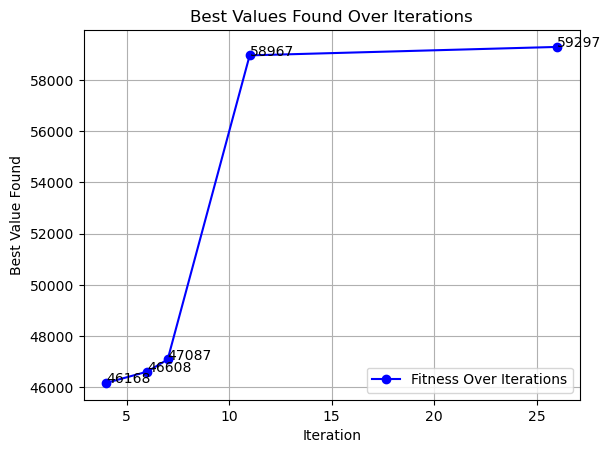

In [13]:
import matplotlib.pyplot as plt

# plotting improvements against iteration numbers
plt.plot(iteration_numbers, total_values, marker='o', linestyle='-', color='b', label='Fitness Over Iterations')

# annotating points with value
for i, txt in enumerate(total_values):
    plt.annotate(txt, (iteration_numbers[i], total_values[i]))

plt.xlabel('Iteration')
plt.ylabel('Best Value Found')
plt.title('Best Values Found Over Iterations')
plt.legend()
plt.grid(True)
plt.show()



The plot shows how many times a better solution was found and recorded for the given iterations. Observing the plot, we can se how the hill-climber moves from one solution to a better one in an increasing trend, improving the best value recorded and discarding solutions with a worse value.

## Part 2

### Genetic Algorithm

To improve the chances of finding a better solution, an approach for this optimisation/search problem could be using a genetic algorithm.

In [14]:
## Reading data from the larger dataset file, same value names

data_file_name = "multi_knap_n200_m25.txt"        

n, m, profits, res, cap = read_multi_knapsack(data_file_name)

print("Instance Data:")
print(f"n: {n}.  m: {m}")
print(f"Profits: {profits}")
print(f"Resources: {res}")
print(f"Capacities: {cap}")

Instance Data:
n: 200.  m: 25
Profits: [ 51  79  73  70  53  53  51  84  72  68  89  65  62  96  76  78  94  63
  82  61  66  55  60  63  50  63  91  65  64  55  80  74  95  96  56  90
  91  60  59  68  80  82 100  70  52  79  62  51  78  95  56  81  75  50
  80  84  83  92  54  72  57  87  84  53  94  75  79  63  84  57  60  92
  92  60  53  72  82  69  84  88  58  70  85  82  55  60  93  87  95  81
  67  53  65  76  69  92  71  76  76  61  75  70  91  95  60  70  50  91
  65  60  98  55  84  75  84  94  63  98  78  64  85  53  79  65  66  99
  77  75  78  71  90  56  98  65  75  85  90  54  68  54  65  95  83  64
  87  63  79  83  70  61  80  51  93  55  62  63  83 100  75  55  91  53
  79  71  61  91  76  50  93  89  57  77  60  60  54  93  53  70  69  74
  84  82  75  90  66  70  95  91 100  98  51  71  54  87  67  73  65  80
  74  56]
Resources: [[ 9  8 11 ... 13 14  6]
 [ 9  8 15 ...  9 15 11]
 [ 5  8 12 ...  8 11  6]
 ...
 [ 8 14  9 ... 10 13  7]
 [ 6 11  9 ... 14  9  8]
 [ 6  8

First, we need to create an individual, with the same logic used to generate a random solution. However, this time we decided to start from random solution generated using a greedy approach. In this way, the algorithm will prioritize selecting the items that have a higher value.
Note: This function always picks the next best items based on our sorting. This is simple and effective,
but it sometimes gets stuck in 'local optima', where it finds a good solution but not necessarily the best possible one.

In [15]:
def greedy_random_solution(n, m, profits, res, cap):
    """
    create a valid, random solution usng a greedy approach

    n: items
    m: constraints
    res: consumption matrix
    cap: capacities of the knapsacks
    return: random, greedy solution as a binay list
    """
    
    ratios = []

    # calculating the average ratio, while ensuring we avoid division
    # by 0, in which case we use the profit value
    for j in range(n):
        average_ratio = np.mean([profits[j] / res[i][j] if res[i][j] != 0 else profits[j] for i in range(m)])
        ratios.append((average_ratio, j))

    # sorting items by average ratio in descending order, prioritising items with a higher profit-to-resource ratio
    sorted_items = sorted(ratios, key=lambda x: x[0], reverse=True)
    solution = [0] * n
    current_cap = cap.copy()

    # start of insertion of items
    for _, item_index in sorted_items:
        item_fits = True
        
        # checking if item fits in each knapsack without exceeding the capacity
        for i in range(m):
            if res[i][item_index] > current_cap[i]:
                item_fits = False
                break
                
        # item fits, add it to solution and update current capacities        
        if item_fits:
            solution[item_index] = 1
            for i in range(m):
                current_cap[i] -= res[i][item_index]
                
    return solution

In [16]:
def create_individual(n, res, cap):
    """
    create a valid solution

    n: items.
    res: consumption matrix.
    cap: capacities of the knapsacks.
    return: binary list representing the individual.
    """
    return greedy_random_solution(n, m, profits, res, cap)

In [17]:
individual_solution = create_individual(n, res, cap)

Then, we create a group of radom solutions of a given size with the method 'create_population'.

In [18]:
def create_population(population_size, n, res, cap):
    """
    Create a population

    population_size: The size of the population.
    n: Number of items.
    res: Resource consumption matrix.
    cap: Capacities of the knapsacks.
    return: A list of individuals forming the population.
    """
    return [create_individual(n, res, cap) for _ in range(population_size)]

In [19]:
population_size = 100
initial_population = create_population(population_size, n, res, cap)

A function that mutates a given solution based on a mutation rate. The mutation rate is adapted (increased) if the solution doesn't improve over a certain amount of generations. In this way, we have more chances to excape local optima.

In [20]:
def mutate(solution, base_mutation_rate, generation_counter, improvement_threshold):
    """
    mutate a solution using an adaptive mutation rate,
    which increases if there hasn't been an improvement for a certain number of generations.
    
    solution: list representing the solution 
    base_mutation_rate: base probability of a gene (element of the solution list) undergoing mutation
    generation_counter: number of generations that have passed without significant improvement
    improvement_threshold: number of generations to wait before considering increasing the mutation rate

    return: mutant solution
    """
    # determining the mutation rate: if the number of generations without improvement exceeds the threshold, 
    # the mutation rate is doubled. In any case, it's kept at 1.0 to avoid probabilities greater than 100%.
    if generation_counter > improvement_threshold:
        mutation_rate = min(1.0, base_mutation_rate * 2)
    else:
        mutation_rate = base_mutation_rate
    
    mutated_solution = solution.copy()

    # iteratation over each gene and decide randomly whether to mutate it
    for i in range(len(mutated_solution)):
        if rnd.random() < mutation_rate:
            mutated_solution[i] = 1 if mutated_solution[i] == 0 else 0

    return mutated_solution


In [21]:
mutated_solution = mutate(individual_solution, 0.1, 0, 2) # params hardcoded to compile
mutant_value = evaluate_value(mutated_solution)
print(f"mutated_individual: {mutated_solution}")
print(f"mutant_value: {mutant_value}")
print(is_valid_solution(mutated_solution, res, cap))

mutated_individual: [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
mutant_value: 7407
False


The tournament selection method will choose a random subset of the population and the individual with the highest value will be selected for being parent in the next generation.
Some parameters are added: k = number of individuals chosen at each tournament, where a larger k means more competition. Then, we added an additional (optional) parameter to further control the competitiveness of the tournament, 'selection_pressure', which regulates how the algorithm favours the fittest solutions when selecting candiates for the tournament. It will multiplied by K, so that for instance if K is large, weaker solutions will have less chance to be considered against the strong ones.

In [22]:
selection_pressure = 3.0
k = 3

def tournament_selection(population, k, selection_pressure):
    """"
    Selects an individual from the population using tournament selection
    It works selecting a random group and pick the best out of them.
    
    population: List of individuals
    k: Number of individuals to be selected for the tournament
    selection_pressure: Controls the selection aggressiveness
    return: The best individual of the tournament
    """
    # calculate the number of solutions to be considered in the tournament
    # multiplying k and pressure of selection
    actual_tournament_size = int(k * selection_pressure)

    # randomly select a subset of individuals for the tournament
    tournament = rnd.choices(population, k=actual_tournament_size)
    # finally find and return the individual with the highest fitness value in the tournament
    best_individual = max(tournament, key=lambda population: population[1])
    
    return best_individual

In [23]:
tournament_sol = tournament_selection(initial_population, k, selection_pressure)
tournament_value = evaluate_value(tournament_sol)
print(f"tournament_sol: {tournament_sol}")
print(f"tournament_value: {tournament_value}")

tournament_sol: [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
tournament_value: 7402


To ensure variety in the solutions, we will perform a multiple point crossover over the two parents solution.
The mixing is done at a specified number of crossover points, where segments
of the parents are alternately switched to form new offspring solutions.

In [24]:
def multipoint_crossover(parent1, parent2, num_points):
    """
    performs a multipoint crossover between two parent solutions.

    parent1: first parent solution
    parent2: second parent solution
    num_points: number of points at which crossover occurs

    return: Two children solutions, each a mix of the parents
    """
    solution_length = len(parent1)
    # limiting the number of crossover points to be less than the solution length
    num_points = min(num_points, solution_length - 1)
    
    # unique crossover points selection
    points = sorted(rnd.sample(range(1, solution_length), num_points))
    child1, child2 = parent1[:], parent2[:]

    # crossover
    for i, point in enumerate(points):
        # segments swap from parents based on odd or even index
        if i % 2 == 0:
            child1[point:], child2[point:] = parent2[point:], parent1[point:]
        else:
            child1[point:], child2[point:] = parent1[point:], parent2[point:]

    return child1, child2

In [25]:
num_points = 3

child1, child2 = multipoint_crossover(initial_population[0], initial_population[1], num_points)
child1_value = evaluate_value(child1)
child2_value = evaluate_value(child2)

print("Child 1 value:", child1_value)
print("Child 2 value:", child2_value)

Child 1 value: 7402
Child 2 value: 7402


Note: both tournament_selection and multiple_point_crossover get to the same solutions and values. This is because we are generating the random solution in a greedy way: if on one side guarantees a good solution, choosing all the items with the best profit until capacity is reached, on the other hand it gets always to the same solution. In this instance, we keep using the greedy selection because we count on improving that throughout further improvements in our genetic algorithm.

In [26]:
def genetic_algorithm(n, res, cap, population_size, num_generations, crossover_points, mutation_rate):
    """
    Genetic algorithm implementation 

    n: items
    res: consumption matrix
    cap: knapsacks
    population_size: size of the population
    num_generations: number of generations to evolve
    crossover_points: number of points to use in crossover
    mutation_rate: probability of mutation per individual
    return: The best solution found and its value
    """
    population = create_population(population_size, n, res, cap)

    evaluated_population = [(individual, evaluate_value(individual)) for individual in population]
    for _ in range(num_generations):
        new_population = []

        # for each new generation round
        while len(new_population) < population_size:
            
            # tournament
            parent1 = tournament_selection(evaluated_population, k, selection_pressure)
            parent2 = tournament_selection(evaluated_population, k, selection_pressure)

            # crossover
            child1, child2 = multipoint_crossover(parent1[0], parent2[0], crossover_points)

            # mutate
            if rnd.random() < mutation_rate:
                child1 = mutate(child1, mutation_rate, 0, 2)
            if rnd.random() < mutation_rate:
                child2 = mutate(child2, mutation_rate, 0, 2)

            # check children validity and add to population
            if is_valid_solution(child1, res, cap):
                new_population.append((child1, evaluate_value(child1)))
            if is_valid_solution(child2, res, cap) and len(new_population) < population_size:
                new_population.append((child2, evaluate_value(child2)))

        # generational chage
        evaluated_population = new_population

    best_solution = max(evaluated_population, key=lambda individual: individual[1])
    return best_solution

In [27]:
best_solution = genetic_algorithm(n, res, cap, population_size=100, num_generations=50, 
    crossover_points=3, mutation_rate=0.02)

print("Best Solution:", best_solution[0])
print("Best Solution Value:", best_solution[1])

Best Solution: [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
Best Solution Value: 7430


## Part 3

### Performance Comparison
For the next section, we will perfom some experiments on the genetic algorithm, modifying some parameters to discover how these changes affect its performance.

The variations we will consider are:

- Different Mutation Rates
- Different Number of Crossover Points: GA with single-point crossover and GA with multiple-point crossover. Having multiple crossover points guarantees more diveristy in the solutions found, even though with slower convergence rate. 
- Tournament selection with different k and selection_pressure
    
In order to guarantee a fair comparison between differents version of the algorithm, we had to guarantee that they will run for the same number of iterations. Because of the stochastic nature of the algorithms, the number of iterations we'll choose will be any number greater than 10 and they will run from the same initial population, to ensure consistency.

In [28]:
population_size = 100
num_generations = 50
num_runs = 10

population = create_population(population_size, n, res, cap)

### Comparing hyper-parameters

The genetic agorithm will be modified to return not just one best solution, but a list of all the best values found for each generation. It also takes some extra parameters and doesn't caluclate the population inside it, so that the analysis we will perform later will be performed on the same population.

In [29]:
def genetic_algorithm_variant(n, res, cap, population_size, num_generations, crossover_points, mutation_rate, population, k, selection_pressure):
    best_values = []

    for _ in range(num_generations):
        new_population = []
        while len(new_population) < population_size:
            # tournament
            parent1 = tournament_selection(population, k, selection_pressure)
            parent2 = tournament_selection(population, k, selection_pressure)
            
            # crossover
            child1, child2 = multipoint_crossover(parent1, parent2, crossover_points)

            # mutation
            if rnd.random() < mutation_rate:
                child1 = mutate(child1, mutation_rate, 0, 2)
            if rnd.random() < mutation_rate:
                child2 = mutate(child2, mutation_rate, 0, 2)

            # check and add children
            if is_valid_solution(child1, res, cap):
                new_population.append(child1)
            if is_valid_solution(child2, res, cap) and len(new_population) < population_size:
                new_population.append(child2)

        population = new_population
        best_solution = max(population, key=lambda individual: evaluate_value(individual))
        best_values.append(evaluate_value(best_solution))

    return best_values

### Different Mutation Rates

Variant A - Genetic Algorithm with Low Mutation Rate (0.02) vs Variant B - Genetic Algorithm with High Mutation Rate (0.05)

In [30]:
mutation_rate_a = 0.02
mutation_rate_b = 0.05

# same number of crossover points
crossover_points = 3

# values for tournament selection
k = 3
selection_pressure = 3.0

results_a = []
results_b = []

In [31]:
for _ in range(num_runs):
    best_values_a = genetic_algorithm_variant(n, res, cap, population_size, num_generations, crossover_points, mutation_rate_a, population, k, selection_pressure)
    best_values_b = genetic_algorithm_variant(n, res, cap, population_size, num_generations, crossover_points, mutation_rate_b, population, k, selection_pressure)
    results_a.append(max(best_values_a))
    results_b.append(max(best_values_b))

Now we will calculate the average performance with average best solution value and variability with standard deviation.

In [32]:
average_a = np.mean(results_a)
std_dev_a = np.std(results_a)
average_b = np.mean(results_b)
std_dev_b = np.std(results_b)

#### Numerical Results

In [33]:
print(f"Variant A - Average Best Solution Value: {average_a}, Standard Deviation: {std_dev_a}")
print(f"Variant B - Average Best Solution Value: {average_b}, Standard Deviation: {std_dev_b}")

Variant A - Average Best Solution Value: 7430.8, Standard Deviation: 5.4552726787943415
Variant B - Average Best Solution Value: 7436.0, Standard Deviation: 7.54983443527075


#### Box Plots

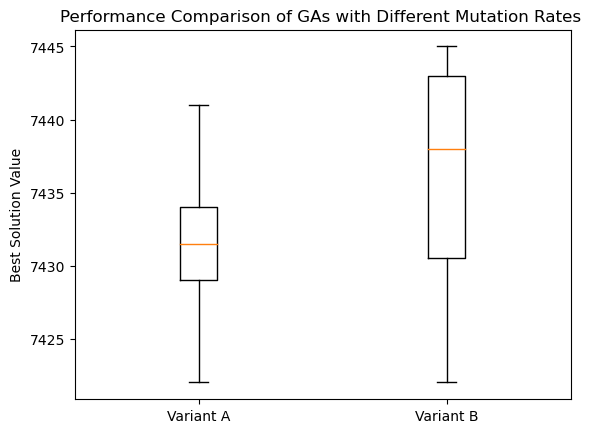

In [34]:
plt.boxplot([results_a, results_b], labels=['Variant A', 'Variant B'])
plt.title('Performance Comparison of GAs with Different Mutation Rates ')
plt.ylabel('Best Solution Value')
plt.show()

Changing the mutation rate, we can increase or decrease the area in which we search for solutions and try to find a balance between exploration an exploitation. Usually, a lower mutation rate can increase the risk of getting stuck into local optima, since the solutions exlored don't vary much from each other. 
Observing the above data, we can conclude that a higher mutation as in Variant B leads to both the discovery of more valuable solutions. It also provides more consistent results (lower standard deviation), since it has less chances of getting stuck into local optima and therefore leading to less variability in the quality of the solutions. These are the reasons that in this instance make Variant B a more valuable choice rather than Variant A.

(Note: Because of the reliance on random process of the algorithms, there could be different outcomes for each run, therefore not matching the above description.
Results I am currently observing are: 
Variant A - Average Best Solution Value: 7428.9, Standard Deviation: 8.34805366537614
Variant B - Average Best Solution Value: 7441.5, Standard Deviation: 8.028075734570521)

### Different Number of Crossover Points

Comparison between single-point crossover (Variant A) and multiple-point crossover (Variant B)

In [35]:
# same mutation rate
mutation_rate = 0.05

crossover_points_a = 1
crossover_points_b = 3

# values for tournament selection
k = 3
selection_pressure = 3.0

results_a = []
results_b = []

In [36]:
for _ in range(num_runs):
    best_values_a = genetic_algorithm_variant(n, res, cap, population_size, num_generations, crossover_points_a, mutation_rate, population, k, selection_pressure)
    best_values_b = genetic_algorithm_variant(n, res, cap, population_size, num_generations, crossover_points_b, mutation_rate, population, k, selection_pressure)
    results_a.append(max(best_values_a))
    results_b.append(max(best_values_b))

In [37]:
average_a = np.mean(results_a)
std_dev_a = np.std(results_a)
average_b = np.mean(results_b)
std_dev_b = np.std(results_b)

#### Numerical Results

In [38]:
print(f"Variant A - Average Best Solution Value: {average_a}, Standard Deviation: {std_dev_a}")
print(f"Variant B - Average Best Solution Value: {average_b}, Standard Deviation: {std_dev_b}")

Variant A - Average Best Solution Value: 7443.1, Standard Deviation: 8.030566605165541
Variant B - Average Best Solution Value: 7441.9, Standard Deviation: 10.41585330157832


#### Box Plots

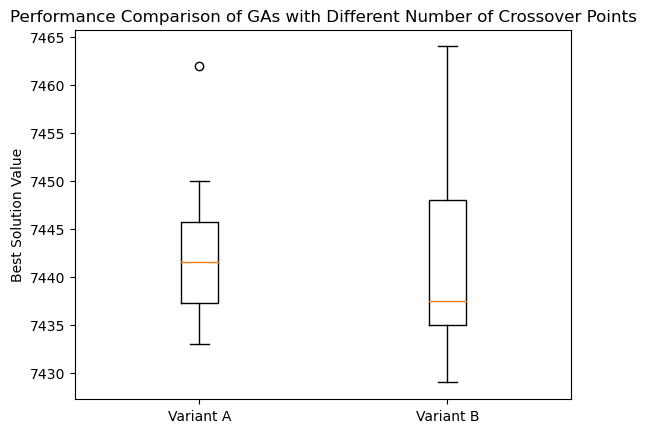

In [39]:
plt.boxplot([results_a, results_b], labels=['Variant A', 'Variant B'])
plt.title('Performance Comparison of GAs with Different Number of Crossover Points')
plt.ylabel('Best Solution Value')
plt.show()

The plots show a slightly better average best solution for Variant B, but since the results of multiple-crossover points are more varied, it has a higher standard deviation than Variant A. On the other hand, Variant A has worse average best solution, but a lower standard deviation.
The choice between the two variants depends on whether the goal is to get the highest solution quality (Variant B), or to preserve consistency to have more preditable solutions (Variant A).

(Results I am looking at: Variant A - Average Best Solution Value: 7436.9, Standard Deviation: 10.319399207318225
Variant B - Average Best Solution Value: 7438.8, Standard Deviation: 14.668333238647124)

### Tournament selection with different k and selection_pressure 

Changing the K and selection_pressure parameters affect the decision on how solutions are selected in the tournament selection. Having K and selection_pressure lower means that we will have tournaments that are less competitive and will allow also to the weaker solutions to be selected. This approach can be convenient because being less strict in the solutions chosen allows more genetic diversity. A higher K ad selection_pressure, however, would make the tournament more competitive to favour just the fittest individuals but likely increasing the risk to get into a premature convergence.


In [40]:
# same mutation rate and crossover points
mutation_rate = 0.05
crossover_points = 3

# variant a - values for tournament selection
k_a = 3
selection_pressure_a = 3.0

# variant b - values for tournament selection
k_b = 5
selection_pressure_b = 4.0

results_a = []
results_b = []

In [41]:
for _ in range(num_runs):
    best_values_a = genetic_algorithm_variant(n, res, cap, population_size, num_generations, crossover_points_a, mutation_rate, population, k_a, selection_pressure_a)
    best_values_b = genetic_algorithm_variant(n, res, cap, population_size, num_generations, crossover_points_b, mutation_rate, population, k_b, selection_pressure_b)
    results_a.append(max(best_values_a))
    results_b.append(max(best_values_b))

In [42]:
average_a = np.mean(results_a)
std_dev_a = np.std(results_a)
average_b = np.mean(results_b)
std_dev_b = np.std(results_b)

In [43]:
print(f"Variant A - Average Best Solution Value: {average_a}, Standard Deviation: {std_dev_a}")
print(f"Variant B - Average Best Solution Value: {average_b}, Standard Deviation: {std_dev_b}")

Variant A - Average Best Solution Value: 7437.3, Standard Deviation: 5.933801479658718
Variant B - Average Best Solution Value: 7437.0, Standard Deviation: 7.14142842854285


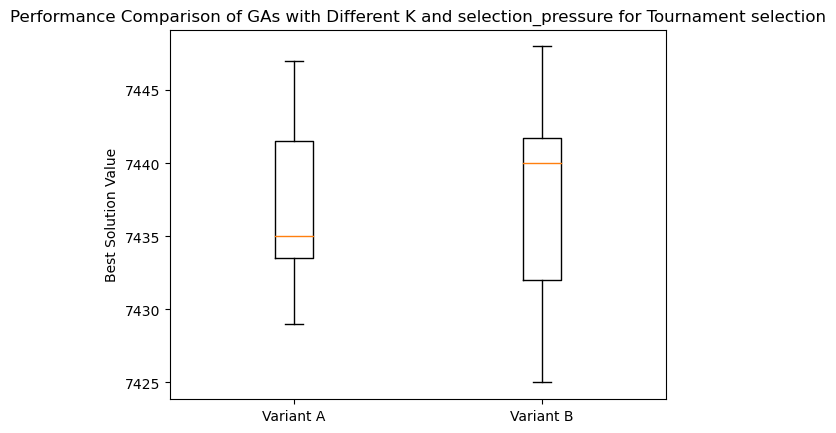

In [44]:
plt.boxplot([results_a, results_b], labels=['Variant A', 'Variant B'])
plt.title('Performance Comparison of GAs with Different K and selection_pressure for Tournament selection')
plt.ylabel('Best Solution Value')
plt.show()

Observing the results, (results I obtained: Variant A - 7418.3, Standard Deviation: 14.825990692024599
Variant B -  7438.3, Standard Deviation: 9.033825324855467) we can conclude that B seems a more favorable options, since it provides better consisteny and performance.